# Lab -  Anomaly Detection

**Objectives**: implement Gaussian distribution model to detect anomalous behavior in server computers. 

While the servers were operating, data regarding the through-put (mb/s) and latency (ms) of response of each server were collected. Vast majority of the servers were acting normal but a few servers were acting anomalously.
On that dataset you will ﬁt a Gaussian distribution of the server features and then identify which are the anomalous samples. 

In [6]:
# Loading relevant libraries
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=RuntimeWarning)

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib
%matplotlib inline

### Load Data 
Load data from file ex9data.mat and get train, test and validation data.

In [18]:
mat=loadmat("ex9data.mat")

Xtrain = mat["Xtrain"]  # only normal examples
Xtest = mat["Xtest"] # normal and a few abnormal examples
Xval = mat["Xval"] # normal and a few abnormal examples
yval = mat["yval"] # labels of the validation examples

#What is the shape of each variable, what is the meaning of the rows and the columns ?
print(Xtrain.shape)
print(Xtest.shape)
print(Xval.shape)
print(yval.shape)
#How many are the normal (label 0) and the abnormal (label 1) validation samples ?
print(f"Normal: {sum(yval==0)} | Abnormal: {sum(yval==1)}")


(300, 2)
(307, 2)
(307, 2)
(307, 1)
Normal: [298] | Abnormal: [9]


### Plot data

<img src="images/im1.png" style="width:600px;height:300px;">
<caption><center> **Fig. 1** : **Latency versus Throughput** </center></caption>

Text(0, 0.5, 'Throughput (mb/s)')

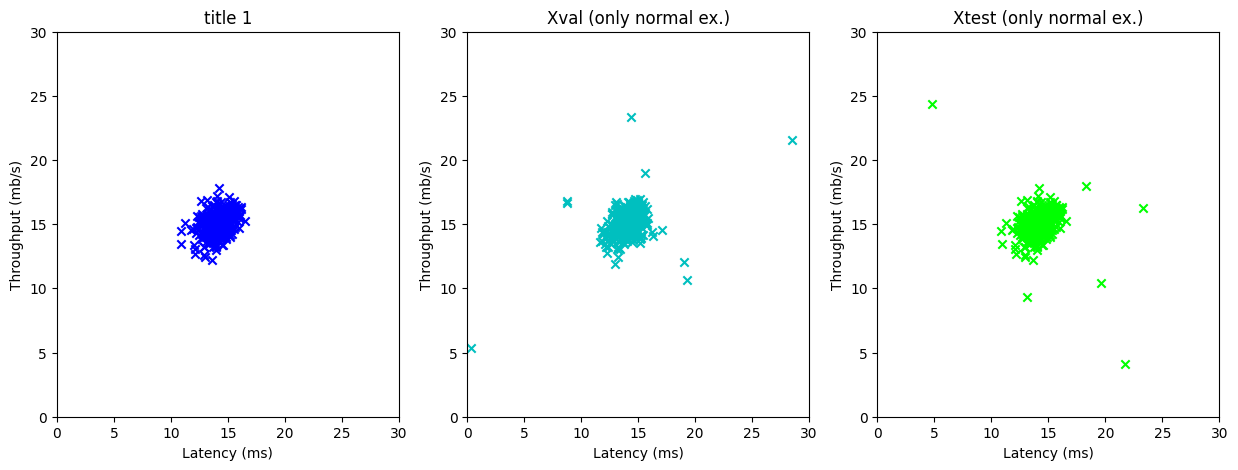

In [45]:
# Plot the scater plots of (Xtrain,Xval, Xtest) and get figure similar to Fig. 1. 
f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.sca(axarr[0]) 
plt.axis([0, 30, 0, 30])
plt.scatter(Xtrain[:,0], Xtrain[:,1], c="b", marker="x")
plt.title("Xtrain (only normal ex.)")
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.title('title 1')

plt.sca(axarr[1])
plt.axis([0, 30, 0, 30])
plt.scatter(Xval[:,0], Xval[:,1], c="c", marker="x")
plt.title("Xval (only normal ex.)")
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

plt.sca(axarr[2])
plt.axis([0, 30, 0, 30])
plt.scatter(Xtest[:,0], Xtest[:,1], c="lime", marker="x")
plt.title("Xtest (only normal ex.)")
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")

### Plot Data

<img src="images/im2.png" style="width:300px;height:250px;">
<caption><center> **Fig. 2** : **Data distribution** </center></caption>

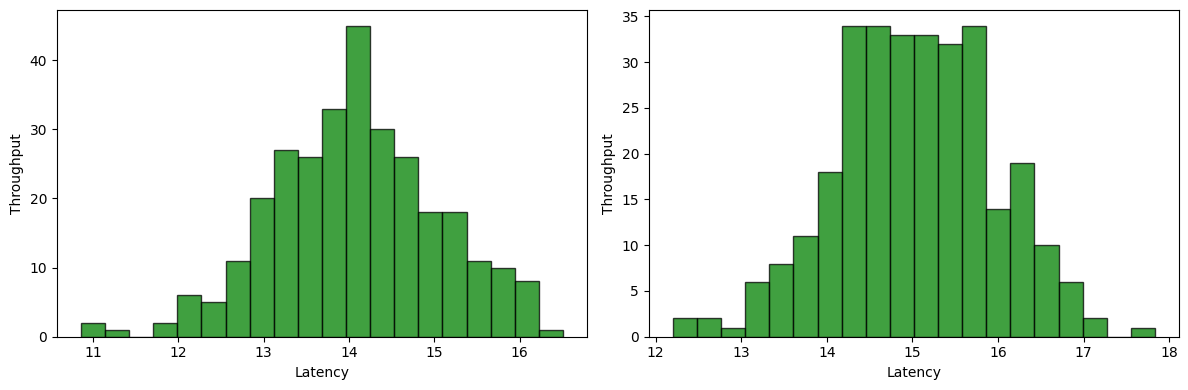

In [48]:
# Plot the histograms of each feature and get figure simular to Fig.2.

# Plot histograms for each feature
n = Xtrain.shape[1]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(Xtrain[:, 0], bins=20, alpha=0.75, color='g', edgecolor='black')
axes[0].set_xlabel('Latency')
axes[0].set_ylabel('Throughput')

axes[1].hist(Xtrain[:, 1], bins=20, alpha=0.75, color='g', edgecolor='black')
axes[1].set_xlabel('Latency')
axes[1].set_ylabel('Throughput')

plt.tight_layout()
plt.show()

### Gaussian Distribution

To perform anomaly detection, you first need to fit a model only to the normal data.

Given a training set {x(1), …, x(m)} (where x(i) ∈ R^n, here n = 2), you want to estimate the Gaussian distribution for each feature (i = 1 . . . n), i.e. find mean and variance (mu, sigma²). 

Gaussian distribution:  $p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)^2}{2\sigma^2}}$

mean:  $\mu_i = \frac{1}{m}\sum^m_{j=1}x^{(j)}$

variance:  $\sigma^2_i = \frac{1}{m}\sum^m_{j=1}(x^{(j)} - \mu_j)^2$

In [51]:
def estimateGaussian(X):
    """
     This function estimates the parameters of a Gaussian distribution using the data in X
    """
    m = X.shape[0]  #number of examples in X
    
    #compute the mean of X per column
    mu = np.mean(X, axis = 0)
     
    # compute variance =sigma^2 of X per column
    sigma2 = np.var(Xtrain, axis=0)
    
    return mu,sigma2

In [54]:
# Estimate mean and variance for the Gaussian model of NORMAL data (Xtrain)
# ANSWER: mu =  [14.06411334 15.02441479] ; sigma2 = [0.93434723 0.8506542 ]

mu, sigma2 = estimateGaussian(Xtrain)
print(f"mu = {mu} ; sigma2 = {sigma2}")



mu = [14.06411334 15.02441479] ; sigma2 = [0.93434723 0.8506542 ]


### Multivariate Gaussian Distribution

Inside function *multivariateGaussian*, $\sigma^2$ vector is converted into the covariance matrix  $\Sigma$.  Assuming the features are independent, each element of vector $\sigma^2$ will be on the diagonal of matrix $\Sigma$ and the rest of the elements are 0. 

The formula for the multivariate probability distribution is:

$p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}} exp(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu))$

In [55]:
#Complete the function
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate Gaussian distribution.
    """
    n = X.shape[1] #number of features 
    sigma_diag=np.diag(sigma2)  #Diagonal matrix (features are independent !!!!)
    X = X - mu.T
    p = 1/((2*np.pi)**(n/2)*(np.linalg.det(sigma_diag)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma_diag) * X,axis=1))
    return p

### Select the threshold $\epsilon$  that will flag an example as anomaly

Dataset is highly unbalanced, accuracy is not a good metrics, therefore F1 score is used to determine the best epsilon. Best parameters are the ones in which F1 score is maximum.

Predict anomaly if pval<epsilon !

Note: try-except block is used to excape zero division when compute precision and recall.

In [56]:
#Complete the function
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to separate normal/anomalous samples
    Best epsilon is when F1 score is max 
    """
    best_epi = 0
    best_F1 = 0
    
    #range of threshold values to decide the best one. 
    stepsize = (max(pval) -min(pval))/1000
    epi_range = np.arange(pval.min(),pval.max(),stepsize)
    for epi in epi_range:
        
        #predictions is a binary vector
        predictions = (pval<epi)[:,np.newaxis]
        
        #compute true positive
        tp = np.sum((predictions == 1) & (yval == 1))
        
        #compute false positive
        fp = np.sum((predictions == 1) & (yval == 0))
        
        #compute false negative 
        fn = np.sum((predictions == 0) & (yval == 1))      
        
        try:
        # compute precision
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0
            
            #compute recall
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            #compute  F1
            F1 = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        
            if F1 > best_F1:
                best_F1 =F1
                best_epi = epi
            
        except ZeroDivisionError:
                print('Warning dividing by zero!!')  
        
    return best_epi, best_F1

In [58]:
# Apply multivariateGaussian to compute the probability of the examples in Xval. 
pval = multivariateGaussian(Xval, mu, sigma2)

#Apply selectThreshold to compute the best epsilon and best F1 with the validation data
epsilon, F1 = selectThreshold(yval, pval)

# What is the Best epsilon ?  => ANSWER: 0.00018
print(f"Best epsilon => {epsilon}")

# What is the Best F1 ? => ANSWER: 0.8235
print(f"Best F1 => {F1}")


Best epsilon => 0.00017841159895769934
Best F1 => 0.823529411764706


**findIndices** returns the indices of faulty servers. This gives a binary vector where 1 means anomaly and 0 means normal.

In [59]:
def findIndices(binVec):
    l = []
    for i in range(len(binVec)):
        if binVec[i] == 1:
            l.append(i)
    return l

In [61]:
# Apply multivariateGaussian to compute the probability of the examples in Xtest
p = multivariateGaussian(Xtest, mu, sigma2)

outl = (p < epsilon)
listOfOutliers=findIndices(outl)

#How many are the Outliers => #ANSWER: 6 
print(f"Number of Outliers => {len(listOfOutliers)}")

#print them
print(listOfOutliers)



Number of Outliers => 6
[300, 301, 303, 304, 305, 306]


### Visualize the anomalies

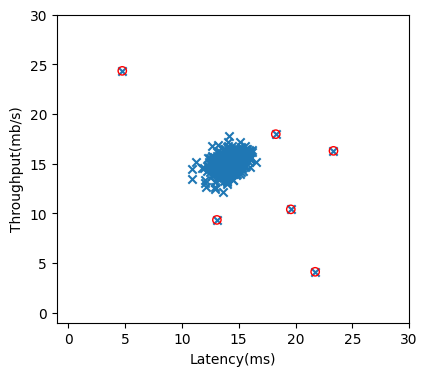

In [62]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(Xtest[:, 0], Xtest[:, 1], marker = "x")
plt.xlabel('Latency(ms)')
plt.ylabel('Throughput(mb/s)')
plt.scatter(Xtest[listOfOutliers,0], Xtest[listOfOutliers, 1], facecolors = 'none', edgecolors = 'r')
plt.xlim(-1,30)
plt.ylim(-1,30)
plt.show()